In [37]:
import spacy
import nltk
import string
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%aimport embedding_search
import embedding_search as es

In [3]:
nlp = spacy.load('en_core_web_lg')

In [4]:
def preprocess(chunk: str):
    chunk = chunk.lower()
    chunk = chunk.translate(str.maketrans('', '', string.punctuation))
    return chunk

def get_vector(chunk: str, nlp):
    preprocessed = preprocess(chunk)
    tokens = nltk.word_tokenize(preprocessed)
    token_embeddings = []
    for token in tokens:
        vec = nlp(token).vector
        if np.all(vec == 0):
            continue
        token_embeddings.append(vec)
    return np.mean(token_embeddings, axis=0)

# checks if cosine similarity scores are calculated correctly
def verify_cos_sim_calc(closest: list[tuple[float, str]], search_key: list[float], eps: float = 1e-5) -> bool: 
    for i in range(len(closest)):
        score, sentence = closest[i]
        returned_vec = get_vector(sentence, nlp)
        cos_sim = np.dot(search_key, returned_vec) / (np.linalg.norm(returned_vec) * np.linalg.norm(search_key))
        if abs(score - (1 - cos_sim)) > eps:
            print(f"Expected: {score}, Actual: {1 - cos_sim}")
            return False
    return True
    

In [5]:
from tqdm import tqdm

# prepare sample data
# data = open("interstellar_raw.txt").read()
# LINES_PER_CHUNK = 3
# lines = data.split("\n")
# chunks = []
# for i in range(0, len(lines), LINES_PER_CHUNK):
#     chunk = " ".join(lines[i:i+LINES_PER_CHUNK])
#     # remove punctuation
#     chunk = preprocess(chunk)
#     chunks.append(chunk)

# tokenized_chunks = [nltk.word_tokenize(chunk) for chunk in chunks]

# data = open("harry-potter-1.txt").read()
data = open("war-and-peace.txt").read()

sentences = nltk.sent_tokenize(data)
preprocessed_sentences = [preprocess(sentence) for sentence in sentences]

# embeddings
embeddings = []
for sentence in tqdm(preprocessed_sentences):
    embeddings.append(get_vector(sentence, nlp))
len(embeddings)

  2%|▏         | 620/32039 [00:21<14:37, 35.82it/s]/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 32039/32039 [19:12<00:00, 27.80it/s]


32039

In [6]:
filtered_embeddings, filtered_sentences = [], []
for i, embedding in enumerate(embeddings):
    if np.isnan(embedding).any():
        continue
    filtered_embeddings.append(embedding)
    filtered_sentences.append(preprocessed_sentences[i])

In [7]:
len(filtered_embeddings), len(filtered_sentences)

(31952, 31952)

In [8]:
with open("filtered_embeddings.pkl", "wb") as f:
    pickle.dump(filtered_embeddings, f)
with open("filtered_sentences.pkl", "wb") as f:
    pickle.dump(filtered_sentences, f)

In [ ]:
filtered_sentences = pickle.load(open("filtered_sentences.pkl", "rb"))
filtered_embeddings = pickle.load(open("filtered_embeddings.pkl", "rb"))

In [11]:
store = es.EmbeddingStore("test/", 300, 1024 * 1024 * 64, 1024 * 1024 * 8)

## Basic Tests

In [12]:
print(f"{len(embeddings) * len(embeddings[0]) * 4} bytes needed for embdedings")
print(f"{len(preprocessed_sentences) * 4 + sum([len(sentence) for sentence in preprocessed_sentences])} bytes needed for values")

38446800 bytes needed for embdedings
3173797 bytes needed for values


In [13]:
for sentence, embedding in zip(filtered_sentences, filtered_embeddings):
    try:
        store.addEmbedding(embedding, sentence)
    except Exception as e:
        print(e)


In [14]:
search_key = get_vector("the great war began", nlp)
closest = store.getKClosest(search_key, 10, 1, es.EmbeddingStore.DistanceMetric.cosine_similarity)
verify_cos_sim_calc(closest, search_key)

True

In [ ]:
closest

In [ ]:
for i in range(len(closest)):
    sentence = closest[i][1]
    # print(sentence)
    idx = preprocessed_sentences.index(sentence)
    
    embedding = embeddings[idx]
    returned_vec = get_vector(sentence, nlp)

    cos_sim = np.dot(search_key, returned_vec) / (np.linalg.norm(returned_vec) * np.linalg.norm(search_key))
    print(np.all(returned_vec == embedding))
    print(1 - cos_sim)

## Speed Benchmarking

In [16]:
hp_queries = [
    "What chapter does Harry first meet Hagrid in 'Harry Potter and the Sorcerer's Stone'?",
    "In which chapter does Harry receive his acceptance letter to Hogwarts?",
    "Can you find the passage where Harry gets his wand from Ollivanders?",
    "What page does Harry receive his Hogwarts letter from Hagrid?",
    "Where in the book does Harry first discover he is a wizard?",
    "What chapter does Harry first enter the magical world through Diagon Alley?",
    "Can you locate the scene where Harry tries on the Sorting Hat?",
    "Where does Harry first meet Ron and Hermione in the book?",
    "What page does Harry first see the Mirror of Erised?",
    "Can you find the passage where Harry learns about Nicolas Flamel?",
    "Where in the book does Harry first encounter the troll in the dungeon?",
    "What chapter does Harry play his first Quidditch match?",
    "Can you locate the scene where Harry discovers the truth about the Sorcerer's Stone?",
    "What page does Harry confront Professor Quirrell in the Forbidden Forest?",
    "Where in the book does Harry encounter Fluffy, the three-headed dog?",
    "What chapter does Harry face Professor Snape in a wizard's duel?",
    "Can you find the passage where Harry finds out about the Philosopher's Stone's protective enchantments?",
    "Where does Harry have his first Potions class?",
    "What page does Harry receive his Nimbus 2000 broomstick?",
    "Can you locate the scene where Harry visits Hagrid's hut for the first time?",
    "What chapter does Harry discover the secret about the Forbidden Corridor?",
    "In which chapter does Harry first meet Draco Malfoy?",
    "Can you find the passage where Harry learns about the Hogwarts Houses?",
    "Where in the book does Harry first encounter Peeves the Poltergeist?",
    "What page does Harry learn about the rules of Quidditch?",
    "Can you locate the scene where Harry receives his first letter from Hogwarts?",
    "Where in the book does Harry meet the Weasley family for the first time?",
    "What chapter does Harry attend his first Transfiguration class?",
    "Can you find the passage where Harry visits Gringotts Wizarding Bank?",
    "What page does Harry receive his Hogwarts Express ticket?",
    "Where in the book does Harry meet the centaur, Firenze?",
    "What chapter does Harry first hear about the Sorcerer's Stone?",
    "Can you locate the scene where Harry sees the Hogwarts Express for the first time?",
    "Where in the book does Harry learn about the Forbidden Forest?",
    "What page does Harry encounter the giant chess set?",
    "Can you find the passage where Harry receives his Invisibility Cloak?",
    "Where does Harry first encounter the moving staircases of Hogwarts?",
    "What chapter does Harry meet Neville Longbottom?",
    "Can you locate the scene where Harry sees the Hogwarts sorting ceremony?",
    "Where in the book does Harry first learn about the House Cup competition?",
    "What page does Harry discover the secret about the Philosopher's Stone?",
    "Can you find the passage where Harry explores the Hogwarts library?",
    "Where does Harry have his first Defense Against the Dark Arts class?",
    "What chapter does Harry attend his first Herbology class?",
    "Can you locate the scene where Harry visits Hagrid's hut at night?",
    "Where in the book does Harry first encounter the portrait of the Fat Lady?",
    "What page does Harry learn about the concept of a Muggle?",
    "Can you find the passage where Harry learns about Platform Nine and Three-Quarters?",
    "Where does Harry first learn about the concept of magic?"
]

war_and_peace_queries = [
    "Where can I find the passage describing Pierre Bezukhov's first encounter with Natasha Rostova?",
    "What page has the scene where Prince Andrei Bolkonsky meets Natasha Rostova at the ball?",
    "In which chapter does Pierre Bezukhov have a conversation with Prince Andrei about life and philosophy?",
    "Can you locate the scene where Natasha Rostova dances with Prince Andrei at a ball?",
    "What page describes the moment when Pierre Bezukhov inherits his father's wealth?",
    "Where in the book does Prince Andrei Bolkonsky join the Russian army and goes to war?",
    "What chapter contains the scene where Pierre Bezukhov attends a Freemason meeting?",
    "Can you find the passage where Natasha Rostova receives a marriage proposal from Prince Andrei?",
    "Where does Pierre Bezukhov marry Helene Kuragina in the book?",
    "What page has the description of the Battle of Borodino?",
    "In which chapter does Prince Andrei get wounded in the Battle of Borodino?",
    "Can you locate the scene where Natasha Rostova takes care of wounded soldiers during the war?",
    "What page describes the moment when Pierre Bezukhov is captured by the French army?",
    "Where in the book does Prince Andrei have his spiritual awakening?",
    "What chapter contains the scene where Pierre Bezukhov confronts Napoleon Bonaparte?",
    "Can you find the passage where Natasha Rostova reunites with Prince Andrei after the war?",
    "Where does Pierre Bezukhov experience imprisonment and hardship in the book?",
    "What page has the description of the burning of Moscow?",
    "In which chapter does Pierre Bezukhov meet Platon Karataev?",
    "Can you locate the scene where Natasha Rostova learns about Prince Andrei's death?",
    "What page describes the moment when Pierre Bezukhov is reunited with Natasha Rostova?",
    "Where in the book does Natasha Rostova forgive Pierre Bezukhov for his past mistakes?",
    "What chapter contains the scene where Pierre Bezukhov reflects on the nature of freedom and responsibility?",
    "Can you find the passage where Prince Andrei's son, Nikolenka, is born?",
    "Where does Natasha Rostova experience personal growth and maturity in the book?",
    "What page has the description of Pierre Bezukhov's reconciliation with his illegitimate son?",
    "In which chapter does Natasha Rostova reflect on the meaning of life and happiness?",
    "Can you locate the scene where Pierre Bezukhov reflects on the lessons learned from his life's journey?",
    "What page describes the moment when Natasha Rostova finds inner peace and contentment?",
    "Where in the book does Pierre Bezukhov contemplate the significance of mortality and legacy?",
    "What chapter contains the scene where Natasha Rostova embraces her role as a wife and mother?",
    "Can you find the passage where Pierre Bezukhov's legacy lives on through his children?",
    "Where does Prince Andrei's sister, Princess Marya, experience personal transformation in the book?",
    "What page has the description of Pierre Bezukhov's final moments?",
    "In which chapter does Natasha Rostova find solace and fulfillment in her family life?",
    "Can you locate the scene where Pierre Bezukhov's ideals and values endure beyond his death?",
    "What page describes the moment when Natasha Rostova reflects on the beauty of life's simplicity?",
    "Where in the book does Prince Andrei's memory continue to inspire those who knew him?",
    "What chapter contains the scene where Pierre Bezukhov's ideals and values endure beyond his death?",
    "Can you find the passage where Natasha Rostova finds strength and resilience in times of adversity?",
    "Where does the novel \"War and Peace\" offer insights into the human condition and the nature of existence?",
    "What page has the description of the timeless themes explored in \"War and Peace\"?",
    "In which chapter does the novel \"War and Peace\" depict the interconnectedness of human lives?",
    "Can you locate the scene where the characters in \"War and Peace\" grapple with the complexities of love and morality?",
    "What page describes the richness of Tolstoy's prose and narrative style in \"War and Peace\"?",
    "Where in the book does \"War and Peace\" offer profound insights into the historical events of the Napoleonic Wars?",
    "What chapter contains the scene where \"War and Peace\" delves into the philosophical underpinnings of human existence?",
    "Can you find the passage where \"War and Peace\" explores the transformative power of personal growth and enlightenment?",
    "Where does \"War and Peace\" present a panoramic view of Russian society and culture?",
    "What page has the description of the novel \"War and Peace\" as a timeless masterpiece of world literature?",
    "In which chapter does \"War and Peace\" challenge conventional notions of heroism and greatness?",
    "Can you locate the scene where \"War and Peace\" celebrates the resilience of the human spirit in the face of adversity?",
    "What page describes the complexity and depth of the characters in \"War and Peace\"?",
    "Where in the book does \"War and Peace\" depict the interplay between fate and free will?",
    "What chapter contains the scene where \"War and Peace\" offers profound reflections on the meaning of life and death?",
    "Can you find the passage where \"War and Peace\" showcases Tolstoy's mastery of storytelling and narrative technique?",
    "Where does \"War and Peace\" explore the themes of love, betrayal, and forgiveness?",
    "What page has the description of the enduring relevance of \"War and Peace\" in today's world?",
    "In which chapter does \"War and Peace\" illustrate the power of human connection and compassion?",
    "Can you locate the scene where \"War and Peace\" captures the beauty and tragedy of the human experience?",
    "What page describes the epic scope and ambition of Tolstoy's vision in \"War and Peace\"?",
    "Where in the book does \"War and Peace\" offer insights into the nature of power and politics?",
    "What chapter contains the scene where \"War and Peace\" explores the dynamics of family and society?",
    "Can you find the passage where \"War and Peace\" highlights the importance of moral integrity and ethical behavior?",
    "Where does the novel \"War and Peace\" delve into the complexities of friendship and loyalty?",
    "What page has the description of the existential themes present in \"War and Peace\"?",
    "In which chapter does the novel \"War and Peace\" depict the struggles of individuals against societal norms?",
    "Can you locate the scene where \"War and Peace\" examines the role of religion and spirituality in people's lives?",
    "What page describes the impact of historical events on personal destinies in \"War and Peace\"?",
    "Where in the book does \"War and Peace\" showcase the consequences of ambition and greed?",
    "What chapter contains the scene where \"War and Peace\" explores the concept of identity and self-discovery?",
    "Can you find the passage where \"War and Peace\" emphasizes the importance of empathy and understanding?",
    "Where does the novel \"War and Peace\" offer commentary on the nature of leadership and governance?",
    "What page has the description of the novel's portrayal of the Russian landscape and environment?",
    "In which chapter does \"War and Peace\" examine the complexities of class and social hierarchy?",
    "Can you locate the scene where \"War and Peace\" reflects on the fleeting nature of human existence?",
    "What page describes the significance of historical accuracy in Tolstoy's depiction of the Napoleonic Wars?",
    "Where in the book does \"War and Peace\" depict the effects of war on civilian populations?",
    "What chapter contains the scene where \"War and Peace\" celebrates the resilience of the human spirit?",
    "Can you find the passage where \"War and Peace\" examines the tension between individual desires and societal expectations?",
    "Where does the novel \"War and Peace\" present contrasting perspectives on morality and ethics?",
    "What page has the description of the novel's exploration of the nature of truth and perception?",
    "In which chapter does \"War and Peace\" challenge traditional notions of heroism and valor?",
    "Can you locate the scene where \"War and Peace\" reflects on the cyclical nature of history?",
    "What page describes the novel's portrayal of the complexities of human relationships?",
    "Where in the book does \"War and Peace\" offer commentary on the inevitability of change and transformation?",
    "What chapter contains the scene where \"War and Peace\" explores the concept of destiny and free will?",
    "Can you find the passage where \"War and Peace\" examines the role of art and literature in society?",
    "Where does the novel \"War and Peace\" critique the institutions of war and governance?",
    "What page has the description of the novel's exploration of the nature of beauty and aesthetics?",
    "In which chapter does \"War and Peace\" emphasize the importance of personal integrity and honor?",
    "Can you locate the scene where \"War and Peace\" depicts the struggles of ordinary people amidst extraordinary circumstances?",
    "What page describes the novel's commentary on the futility of human endeavors?",
    "Where in the book does \"War and Peace\" examine the intersection of love and duty?",
    "What chapter contains the scene where \"War and Peace\" offers insights into the psychology of human behavior?",
    "Can you find the passage where \"War and Peace\" reflects on the complexities of human emotion?",
    "Where does the novel \"War and Peace\" present contrasting views on the nature of heroism?",
    "What page has the description of the novel's exploration of the concept of honor?",
    "In which chapter does \"War and Peace\" challenge traditional gender roles and expectations?",
    "Can you locate the scene where \"War and Peace\" explores the theme of sacrifice?",
    "What page describes the novel's examination of the impact of war on individuals?",
    "Where in the book does \"War and Peace\" reflect on the relationship between power and corruption?",
    "What chapter contains the scene where \"War and Peace\" portrays the resilience of the human spirit?",
    "Can you find the passage where \"War and Peace\" examines the nature of forgiveness?",
    "Where does the novel \"War and Peace\" offer commentary on the pursuit of happiness?",
    "What page has the description of the novel's exploration of the nature of suffering?",
    "In which chapter does \"War and Peace\" depict the tension between tradition and progress?",
    "Can you locate the scene where \"War and Peace\" reflects on the inevitability of death?",
    "What page describes the novel's portrayal of the impact of societal norms on individual lives?",
    "Where in the book does \"War and Peace\" examine the concept of justice?",
    "What chapter contains the scene where \"War and Peace\" explores the theme of redemption?",
    "Can you find the passage where \"War and Peace\" examines the concept of identity?",
    "Where does the novel \"War and Peace\" offer commentary on the nature of leadership?",
    "What page has the description of the novel's examination of the role of chance in human affairs?",
    "In which chapter does \"War and Peace\" explore the theme of existentialism?",
    "Can you locate the scene where \"War and Peace\" reflects on the relationship between war and peace?",
    "What page describes the novel's portrayal of the human capacity for resilience?",
    "Where in the book does \"War and Peace\" examine the theme of disillusionment?",
    "What chapter contains the scene where \"War and Peace\" explores the concept of destiny?",
    "Can you find the passage where \"War and Peace\" examines the theme of friendship?",
    "Where does the novel \"War and Peace\" offer commentary on the nature of truth?",
    "What page has the description of the novel's exploration of the concept of beauty?",
    "In which chapter does \"War and Peace\" depict the theme of betrayal?",
    "Can you locate the scene where \"War and Peace\" reflects on the concept of legacy?",
    "What page describes the novel's portrayal of the human capacity for love?",
    "Where in the book does \"War and Peace\" explore the theme of identity?",
    "What chapter contains the scene where \"War and Peace\" examines the concept of sacrifice?",
    "Can you find the passage where \"War and Peace\" explores the theme of family?",
    "Where does the novel \"War and Peace\" offer commentary on the nature of power?",
    "What page has the description of the novel's exploration of the concept of fate?",
    "In which chapter does \"War and Peace\" depict the theme of forgiveness?",
    "Can you locate the scene where \"War and Peace\" reflects on the concept of honor?",
    "What page describes the novel's portrayal of the theme of redemption?",
    "Where in the book does \"War and Peace\" explore the theme of suffering?",
    "What chapter contains the scene where \"War and Peace\" examines the concept of justice?",
    "Can you find the passage where \"War and Peace\" explores the theme of friendship?",
    "Where does the novel \"War and Peace\" offer commentary on the theme of loyalty?",
    "What page has the description of the novel's exploration of the concept of duty?",
    "In which chapter does \"War and Peace\" depict the theme of courage?",
    "Can you locate the scene where \"War and Peace\" reflects on the concept of fate?",
    "What page describes the novel's portrayal of the theme of resilience?",
    "Where in the book does \"War and Peace\" explore the theme of ambition?",
    "What chapter contains the scene where \"War and Peace\" examines the concept of love?",
    "Can you find the passage where \"War and Peace\" explores the theme of betrayal?",
    "Where does the novel \"War and Peace\" offer commentary on the theme of legacy?",
    "What page has the description of the novel's exploration of the concept of freedom?",
    "In which chapter does \"War and Peace\" depict the theme of compassion?",
    "Can you locate the scene where \"War and Peace\" reflects on the concept of mortality?",
    "What page describes the novel's portrayal of the theme of transformation?",
    "Where in the book does \"War and Peace\" explore the theme of identity?",
    "What chapter contains the scene where \"War and Peace\" examines the concept of power?",
    "Can you find the passage where \"War and Peace\" explores the theme of wisdom?",
    "Where does the novel \"War and Peace\" offer commentary on the theme of truth?",
    "What page has the description of the novel's exploration of the concept of happiness?",
    "In which chapter does \"War and Peace\" depict the theme of suffering?",
    "Can you locate the scene where \"War and Peace\" reflects on the concept of honor?",
    "What page describes the novel's portrayal of the theme of courage?",
    "Where in the book does \"War and Peace\" explore the theme of fate?",
    "What chapter contains the scene where \"War and Peace\" examines the concept of loyalty?",
    "Can you find the passage where \"War and Peace\" explores the theme of duty?",
    "Where does the novel \"War and Peace\" offer commentary on the theme of justice?",
    "What page has the description of the novel's exploration of the concept of destiny?",
    "In which chapter does \"War and Peace\" depict the theme of compassion?",
    "Can you locate the scene where \"War and Peace\" reflects on the concept of resilience?",
    "What page describes the novel's portrayal of the theme of transformation?",
    "Where in the book does \"War and Peace\" explore the theme of love?",
    "What chapter contains the scene where \"War and Peace\" examines the concept of power?",
    "Can you find the passage where \"War and Peace\" explores the theme of wisdom?",
    "Where does the novel \"War and Peace\" offer commentary on the theme of truth?",
    "What page has the description of the novel's exploration of the concept of happiness?",
    "In which chapter does \"War and Peace\" depict the theme of suffering?",
    "Can you locate the scene where \"War and Peace\" reflects on the concept of honor?",
    "What page describes the novel's portrayal of the theme of courage?",
    "Where in the book does \"War and Peace\" explore the theme of fate?",
    "What chapter contains the scene where \"War and Peace\" examines the concept of loyalty?",
    "Can you find the passage where \"War and Peace\" explores the theme of duty?",
    "Where does the novel \"War and Peace\" offer commentary on the theme of justice?",
    "What page has the description of the novel's exploration of the concept of destiny?",
    "In which chapter does \"War and Peace\" depict the theme of compassion?",
    "Can you locate the scene where \"War and Peace\" reflects on the concept of resilience?",
    "What page describes the novel's portrayal of the theme of transformation?",
    "Where in the book does \"War and Peace\" explore the theme of love?",
    "What chapter contains the scene where \"War and Peace\" examines the concept of power?",
    "Can you find the passage where \"War and Peace\" explores the theme of wisdom?",
    "Where does the novel \"War and Peace\" offer commentary on the theme of truth?",
    "What page has the description of the novel's exploration of the concept of happiness?",
    "In which chapter does \"War and Peace\" depict the theme of suffering?",
    "Can you locate the scene where \"War and Peace\" reflects on the concept of honor?",
    "What page describes the novel's portrayal of the theme of courage?",
    "Where in the book does \"War and Peace\" explore the theme of fate?",
    "What chapter contains the scene where \"War and Peace\" examines the concept of loyalty?",
    "Can you find the passage where \"War and Peace\" explores the theme of duty?",
    "Where does the novel \"War and Peace\" offer commentary on the theme of justice?",
    "What page has the description of the novel's exploration of the concept of destiny?",
    "In which chapter does \"War and Peace\" depict the theme of compassion?",
    "Can you locate the scene where \"War and Peace\" reflects on the concept of resilience?",
    "What page describes the novel's portrayal of the theme of transformation?",
    "Where in the book does \"War and Peace\" explore the theme of love?",
    "What chapter contains the scene where \"War and Peace\" examines the concept of power?",
    "Can you find the passage where \"War and Peace\" explores the theme of wisdom?"
]

In [26]:
#%%timeit
k = 8
mmap_results = []
for query in war_and_peace_queries:
    search_key = get_vector(query, nlp)
    closest = store.getKClosest(search_key, k, 4, es.EmbeddingStore.DistanceMetric.cosine_similarity)
    mmap_results.append(closest)
    # assert(verify_cos_sim_calc(closest, search_key))

In [ ]:
store.close()

## How long do other vector stores take?

In [ ]:
!pip install chromadb

In [21]:
## Chroma
import chromadb
chroma_client = chromadb.PersistentClient("chroma-test/")
collection = chroma_client.get_or_create_collection(
    name="war-and-peace-test",
    metadata={
        "hnsw:space": "cosine"
    }
)
collection.count()

0

In [22]:
embedding_list = [
    [float(x) for x in embedding_arr] for embedding_arr in filtered_embeddings
]

collection.add(
    embeddings=embedding_list,
    documents=filtered_sentences,
    ids=[str(i) for i in range(len(filtered_sentences))]
)

# idx = 0
# for (em, sent) in zip(embedding_list, filtered_sentences):
#     collection.add(
#         embeddings=em,
#         documents=sent,
#         ids=str(idx)
#     )
#     idx += 1

In [23]:
collection.count()

31952

In [29]:
# %%timeit
chroma_results = []
for query in war_and_peace_queries:
    search_key = get_vector(query, nlp)
    float_search_key = [float(x) for x in search_key]
    chroma_results.append(collection.query(query_embeddings=[float_search_key], n_results=8))

In [26]:
chroma_client.delete_collection("hp-test")

In [34]:
mean_diffs = []
for mmap_result, chroma_result in zip(mmap_results, chroma_results):
    mmap_dists = [p[0] for p in mmap_result]
    chroma_dists = chroma_result["distances"][0]
    diff = np.array(mmap_dists) - np.array(chroma_dists)
    mean_diffs.append(np.mean(diff))

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,
         1.,  1.,  2.,  4.,  3.,  2.,  8., 12., 29., 41., 91.]),
 array([-1.72785991e-02, -1.69330188e-02, -1.65874385e-02, -1.62418583e-02,
        -1.58962780e-02, -1.55506977e-02, -1.52051174e-02, -1.48595371e-02,
        -1.45139568e-02, -1.41683765e-02, -1.38227962e-02, -1.34772160e-02,
        -1.31316357e-02, -1.27860554e-02, -1.24404751e-02, -1.20948948e-02,
        -1.17493145e-02, -1.14037342e-02, -1.10581540e-02, -1.07125737e-02,
        -1.03669934e-02, -1.00214131e-02, -9.67583281e-03, -9.33025252e-03,
        -8.98467224e-03, -8.63909195e-03, -8.29351167e-03, -7.94793138e-03,
        -7.60235109e-03, -7.25677081e-03, -6.91119052e-03, -6.56561023e-03,
        -6.22002995e-03, -5.87444966e-03, -5.52886937e-03, -5.18328909e-03,
        -4.83770880e-03, -4.4921

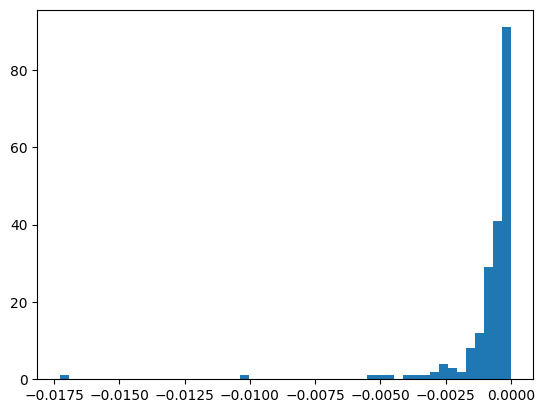

In [38]:
plt.hist(mean_diffs, bins=50)